In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

data: np.ndarray = pd.read_csv("/kaggle/input/cities/Dubai.csv").values

In [33]:
# convert date to number of days since 01/01/2020
def days_since_zero_date(date_str: str) -> int:
    # Converting a string to a datetime object
    date_format: str = "%Y-%m-%d"
    
    date_obj = datetime.strptime(date_str, date_format)
    
    zero_date = datetime.strptime("2020-01-01", date_format)
    delta = date_obj - zero_date
    days = delta.days
    return days

data[:, 0] = np.vectorize(days_since_zero_date)(data[:, 0])

data = data.astype("float")
print(data)

[[0.000e+00 2.130e+01 6.300e+01 2.150e+01]
 [1.000e+00 2.170e+01 7.500e+01 1.700e+01]
 [2.000e+00 2.130e+01 7.000e+01 1.210e+01]
 ...
 [1.891e+03 2.420e+01 4.800e+01 1.700e+01]
 [1.892e+03 2.760e+01 2.800e+01 1.450e+01]
 [1.893e+03 2.880e+01 2.000e+01 1.390e+01]]


In [34]:
ratio = 0.9
index = int(data.shape[0] * ratio)
train_data = data[:index]
test_data = data[index:]
print(train_data)

[[0.000e+00 2.130e+01 6.300e+01 2.150e+01]
 [1.000e+00 2.170e+01 7.500e+01 1.700e+01]
 [2.000e+00 2.130e+01 7.000e+01 1.210e+01]
 ...
 [1.701e+03 3.440e+01 7.200e+01 2.870e+01]
 [1.702e+03 3.440e+01 6.400e+01 1.900e+01]
 [1.703e+03 3.390e+01 7.600e+01 2.020e+01]]


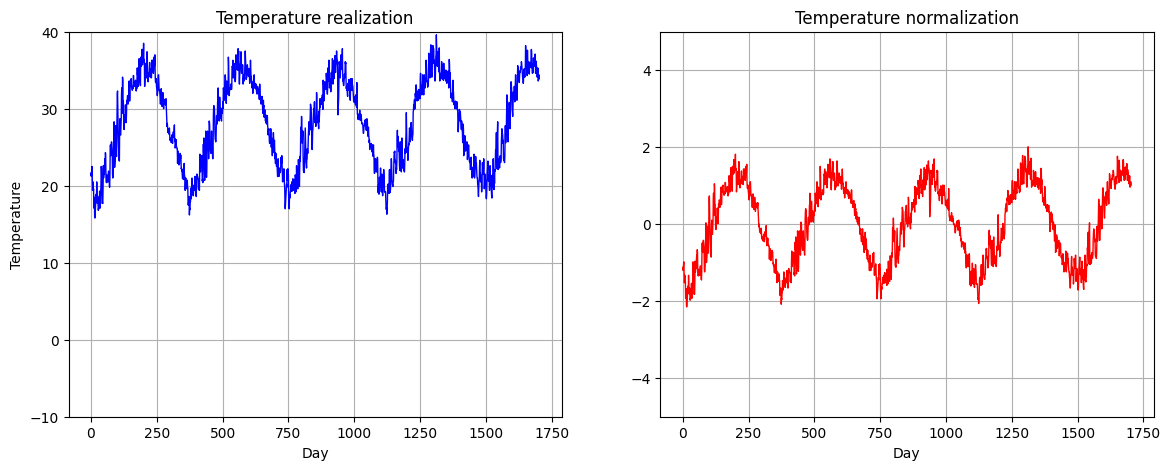

In [35]:
# Data Normalization Layer
class Normalize:
    def __init__(self, data: np.ndarray) -> None:
        self.data: np.ndarray = np.copy(data)
        self.__mean: np.ndarray = data.mean(axis=0)
        self.__std_dev: np.ndarray = data.std(axis=0)
        # Avoid dividing by zero
        self.__std_dev[self.__std_dev == 0] = 1.0

    def normalizeData(self) -> np.ndarray:
        return (self.data - self.__mean) / self.__std_dev

    def DeNormalizeData(self, normalized_data: np.ndarray, axes=None) -> np.ndarray:
        if axes is None:
            return normalized_data * self.__std_dev + self.__mean
        else:
            return normalized_data * self.__std_dev[axes] + self.__mean[axes]

train_normalize_class = Normalize(train_data[:, 1:])

normalized_data = train_normalize_class.normalizeData()  

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Set axis limits and labels
ax[1].set_ylim([-5, 5])  
ax[0].set_ylim([-10, 40])

ax[0].set_ylabel("Temperature")
ax[0].set_xlabel("Day")
ax[1].set_xlabel("Day")

ax[0].set_title("Temperature realization")
ax[1].set_title("Temperature normalization")

ax[0].grid()
ax[1].grid()

ax[0].plot(train_data[:, 1], c="b", linewidth=1)
ax[1].plot(normalized_data[:, 0], c="r", linewidth=1)

plt.show()

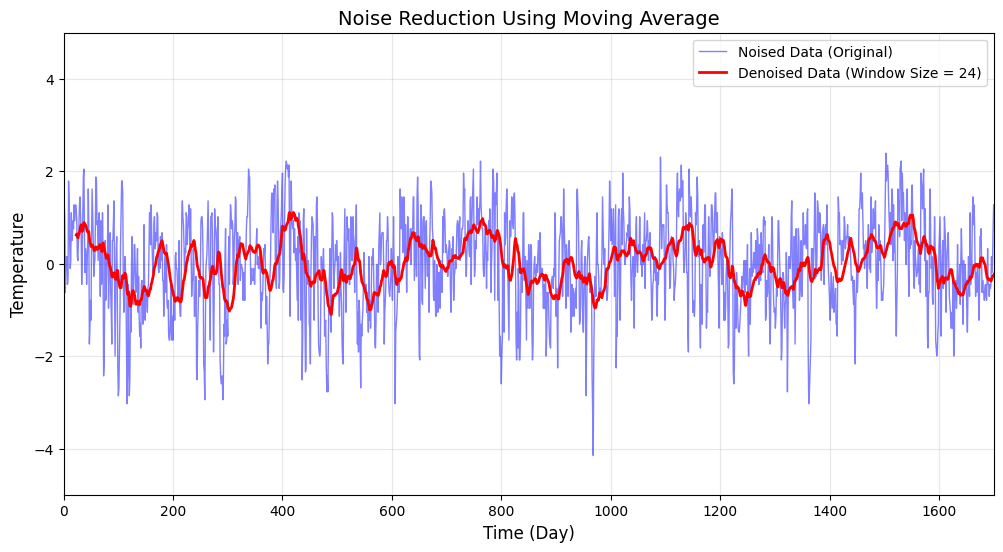

In [36]:
#  Data Smoothing
window_size = normalized_data.shape[0]//70  
denoised_train = (
    pd.Series(normalized_data[:, 1])  
    .rolling(window=window_size)
    .mean()
    .iloc[window_size - 1:]
    .values
)

# Graph
plt.figure(figsize=(12, 6))  

# normalized data (noised data)
plt.plot(normalized_data[:, 1], 
         c="blue", 
         alpha=0.5,  
         linewidth=1, 
         label="Noised Data (Original)")

# smooted data (denoised data)
plt.plot(np.arange(window_size - 1, len(normalized_data)), 
         denoised_train, 
         c="red", 
         linewidth=2, 
         label=f"Denoised Data (Window Size = {window_size})")

plt.title("Noise Reduction Using Moving Average", fontsize=14)
plt.xlabel("Time (Day)", fontsize=12)
plt.ylabel("Temperature", fontsize=12)
plt.ylim(-5, 5)  
plt.xlim(0, 1700)
plt.grid(alpha=0.3)
plt.legend()  

plt.show()

In [37]:
# smoothing data with moving average
def denoise_data(data: np.ndarray, window_size: int) -> np.ndarray:
    return pd.Series(data).rolling(window=window_size).mean().iloc[window_size - 1:].values
    
# Caculate MAE
def MAE(predictions: np.ndarray, labels: np.ndarray) -> float:
    return np.mean(np.abs(predictions - labels))

# Find the main frequency by Fourier transform
def find_dominant_frequencies(data: np.ndarray, num_frequencies: int) -> np.ndarray:
    mfft: np.ndarray = np.fft.fft(data)
    imax: np.ndarray = np.argsort(np.absolute(mfft))[::-1]
    imax = imax[:num_frequencies]
    frequencies: np.ndarray = np.array(imax) / len(data)
    return frequencies

# processing for each city and parameter
def train_model_with_params(x_data, y_data, init_params, bias, number_of_sinuses, 
                           learning_rate, beta_1, beta_2, epochs=50):
    
    # Model
    class SinLayer(layers.Layer):
        def __init__(self):
            super(SinLayer, self).__init__()

        def build(self, _):
            self.kernel = self.add_weight(name="kernel", shape=(number_of_sinuses, 3), trainable=True)
            self.bias = self.add_weight(name="bias", shape=(), trainable=True)

        def call(self, inputs):
            result = 0
            for i in range(number_of_sinuses):
                result += self.kernel[i][0] * tf.sin(
                    self.kernel[i][1] * inputs + self.kernel[i][2]
                )
            return result + self.bias
    
    # Model Building
    inputs = keras.Input(shape=(1,))
    outputs = SinLayer()(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    # Set initial weights
    model.set_weights([init_params, bias])
    
    history = model.fit(x_data, y_data, epochs=epochs, verbose=0)
    
    return model, history

In [38]:
# grid search to find optimal parameters for each city and parameter
def grid_search_optimizer(city_file, parameter, number_of_sinuses=4, cv_folds=3):
    # Read data
    city_name = os.path.basename(city_file).replace('.csv', '')
    print(f"Optimized for {city_name} - {parameter}...")
    
    df = pd.read_csv(city_file)
    
    # Check if parameter exists
    if parameter not in df.columns:
        print(f"  Parameter {parameter} is not present in the data")
        return None, None, None
    
    # Convert date
    df['days'] = df['date'].apply(days_since_zero_date)
    
    # Prepart data
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    # Normalize parameter data
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    normalized_data = normalize_class.normalizeData().flatten()
    
    # Data Smoothing
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        print(f"  Not enough data for {parameter}")
        return None, None, None
    
    denoised_data = denoise_data(normalized_data, window_size)
    
    # Frequency calculation via Fourier transform
    x_data = np.linspace(0, len(denoised_data), len(denoised_data))
    frequencies = find_dominant_frequencies(denoised_data, number_of_sinuses)
    
    # Initialize parameters
    init_params = np.array([
        np.array([np.std(denoised_data), frequencies[i] * 2 * np.pi, 0.0])
        for i in range(number_of_sinuses)
    ])
    bias = np.mean(denoised_data)

    learning_rates = [0.001]
    beta_1_values = [0.7, 0.8, 0.9]
    beta_2_values = [0.9, 0.95, 0.99]
    
    # Tạo KFold cross-validator
    # kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    best_params = None
    best_mae = float('inf')
    
    # grid search
    for lr in learning_rates:
        for b1 in beta_1_values:
            for b2 in beta_2_values:
                # Ignore when beta_2 <= beta_1 (invalid for Adam)
                if b2 <= b1:
                    continue
                
                cv_maes = []
                
                # Cross-validation
                for train_idx, val_idx in tscv.split(x_data):
                    x_train, x_val = x_data[train_idx], x_data[val_idx]
                    y_train, y_val = denoised_data[train_idx], denoised_data[val_idx]
                
                    model, _ = train_model_with_params(
                        x_train, y_train, init_params, bias, number_of_sinuses,
                        lr, b1, b2, epochs=10
                    )
                    
                    # Prediction on validation set
                    val_preds = model.predict(x_val.reshape(-1, 1), verbose=0)
                    
                    # Calculate MAE on standardized data
                    val_mae = MAE(val_preds.flatten(), y_val)
                    cv_maes.append(val_mae)
                
                # Calculate average MAE over folds
                avg_mae = np.mean(cv_maes)
                
                # Check if this is the best parameter
                if avg_mae < best_mae:
                    best_mae = avg_mae
                    best_params = {'learning_rate': lr, 'beta_1': b1, 'beta_2': b2}
                    print(f"  Better parameters found: {best_params}, MAE: {best_mae:.6f}")
    
    if best_params:
        # Train the final model with the best parameters on the entire dataset
        final_model, history = train_model_with_params(
            x_data, denoised_data, init_params, bias, number_of_sinuses,
            best_params['learning_rate'], best_params['beta_1'], best_params['beta_2'],
            epochs=50
        )
        
        print(f"  Optimized parameters for {city_name} - {parameter}: {best_params}")
        return final_model, best_params, best_mae, history
    else:
        return None, None, None, None

In [39]:
# Get the list of file CSV
cities_files = glob.glob('/kaggle/input/cities-3/*.csv')

# List of parameters to be modeled
parameters = ['temperature_avg', 'humidity_avg', 'wind_speed_max']

results = {}

for city_file in cities_files:
    city_name = os.path.basename(city_file).replace('.csv', '')
    results[city_name] = {'models': {}, 'best_params': {}, 'metrics': {}, 'histories': {}} 
    
    for param in parameters:
        model, best_params, mae, history = grid_search_optimizer(city_file, param)
        if model is not None:
            results[city_name]['models'][param] = model
            results[city_name]['best_params'][param] = best_params
            results[city_name]['metrics'][param] = mae
            results[city_name]['histories'][param] = history

print("\nOptimization results:")
for city_name, city_results in results.items():
    print(f"\nCity: {city_name}")
    for param in city_results['best_params']:
        print(f"  - {param}: ")
        print(f"    + Optimal parameter: {city_results['best_params'][param]}")
        print(f"    + MAE: {city_results['metrics'][param]:.6f}")
        print(f"    + Loss: {city_results['histories'][param].history['loss'][-1]:.6f}")

Optimized for Hanoi - temperature_avg...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 1.058942
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.99}, MAE: 1.044011
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.95}, MAE: 0.888542
  Optimized parameters for Hanoi - temperature_avg: {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.95}
Optimized for Hanoi - humidity_avg...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 0.590667
  Optimized parameters for Hanoi - humidity_avg: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}
Optimized for Hanoi - wind_speed_max...
  Better parameters found: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}, MAE: 0.289940
  Optimized parameters for Hanoi - wind_speed_max: {'learning_rate': 0.001, 'beta_1': 0.7, 'beta_2': 0.9}
Optimized for Moscow - temperature_avg...
  Better parameters found: {'learn

In [40]:
# analys
optimal_learning_rates = {}
optimal_beta_1s = {}
optimal_beta_2s = {}

for param in parameters:
    optimal_learning_rates[param] = []
    optimal_beta_1s[param] = []
    optimal_beta_2s[param] = []
    
    for city_name, city_results in results.items():
        if param in city_results['best_params'] and city_results['best_params'][param]:
            optimal_learning_rates[param].append(city_results['best_params'][param]['learning_rate'])
            optimal_beta_1s[param].append(city_results['best_params'][param]['beta_1'])
            optimal_beta_2s[param].append(city_results['best_params'][param]['beta_2'])

# dispersion of optimal parameters
print("\nDispersion of optimal parameters:")
for param in parameters:
    if optimal_learning_rates[param]:
        print(f"\n{param}:")
        print(f"  - Learning rate: mean={np.mean(optimal_learning_rates[param]):.6f}, std={np.std(optimal_learning_rates[param]):.6f}")
        print(f"  - Beta 1: mean={np.mean(optimal_beta_1s[param]):.6f}, std={np.std(optimal_beta_1s[param]):.6f}")
        print(f"  - Beta 2: mean={np.mean(optimal_beta_2s[param]):.6f}, std={np.std(optimal_beta_2s[param]):.6f}")


Dispersion of optimal parameters:

temperature_avg:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.760000, std=0.080000
  - Beta 2: mean=0.930000, std=0.024495

humidity_avg:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.780000, std=0.097980
  - Beta 2: mean=0.936000, std=0.044091

wind_speed_max:
  - Learning rate: mean=0.001000, std=0.000000
  - Beta 1: mean=0.780000, std=0.074833
  - Beta 2: mean=0.928000, std=0.036551


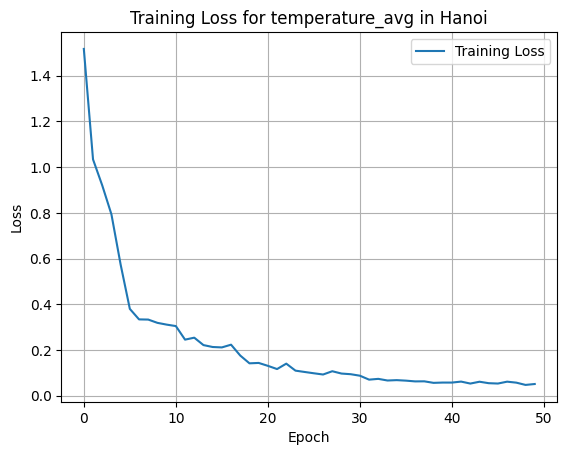

In [41]:
city_name = 'Hanoi'  
param = 'temperature_avg'

training_history = results[city_name]['histories'][param]

plt.plot(training_history.history['loss'], label='Training Loss')
plt.title(f'Training Loss for {param} in {city_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

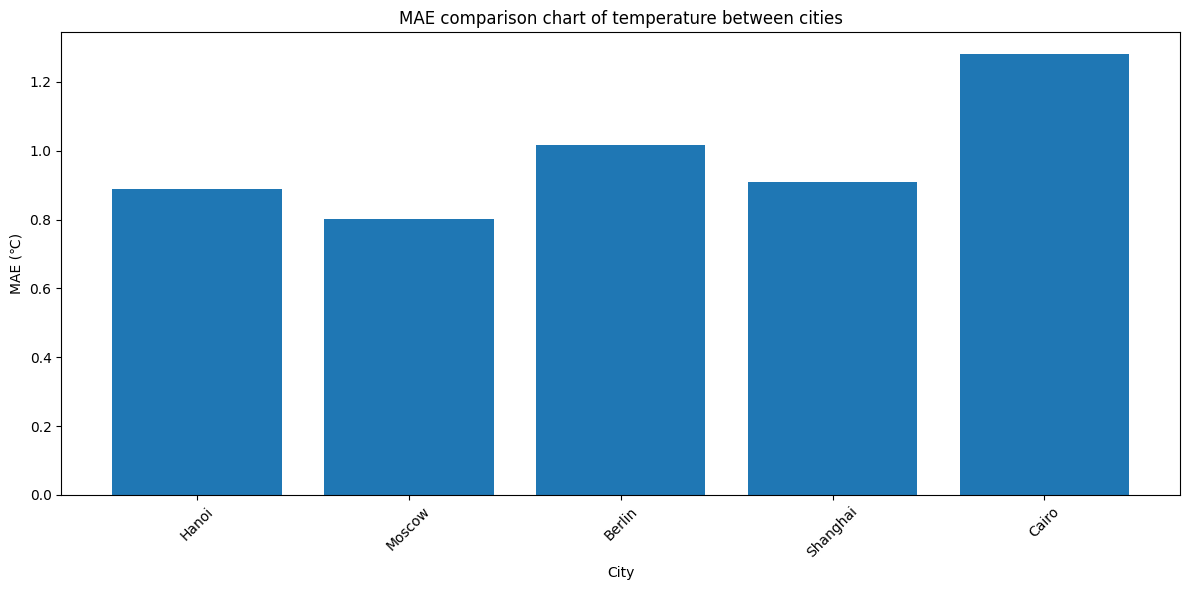

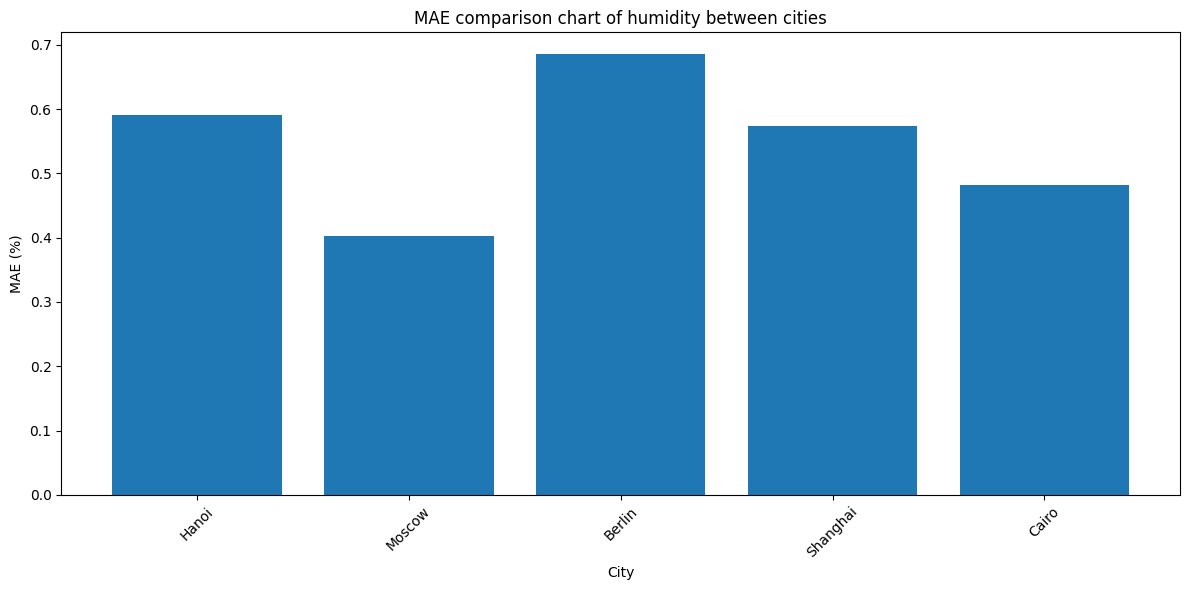

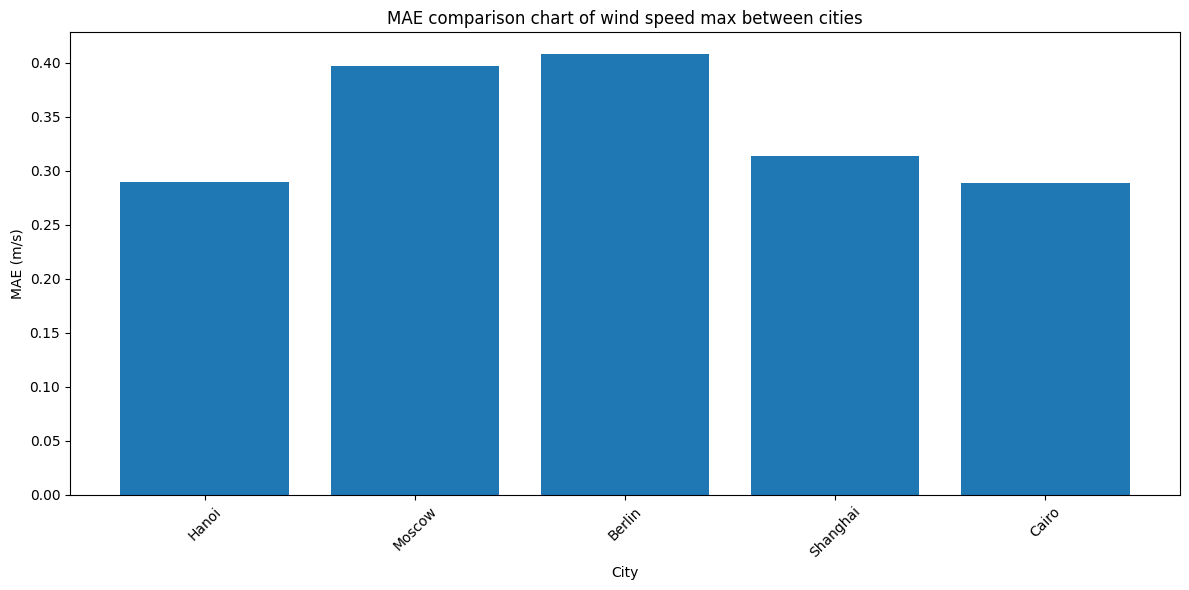

In [42]:
# MAE comparison chart of temperature between cities
cities = [city for city in results.keys() if 'temperature_avg' in results[city]['metrics']]
temps_mae = [results[city]['metrics']['temperature_avg'] for city in cities]

if cities and temps_mae:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_mae)
    plt.title('MAE comparison chart of temperature between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (℃)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

temps_hum = [results[city]['metrics']['humidity_avg'] for city in cities]

if cities and temps_hum:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_hum)
    plt.title('MAE comparison chart of humidity between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cities = [city for city in results.keys() if 'wind_speed_max' in results[city]['metrics']]
temps_wind = [results[city]['metrics']['wind_speed_max'] for city in cities]

if cities and temps_wind:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_wind)
    plt.title('MAE comparison chart of wind speed max between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (m/s)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Hanoi - temperature_avg


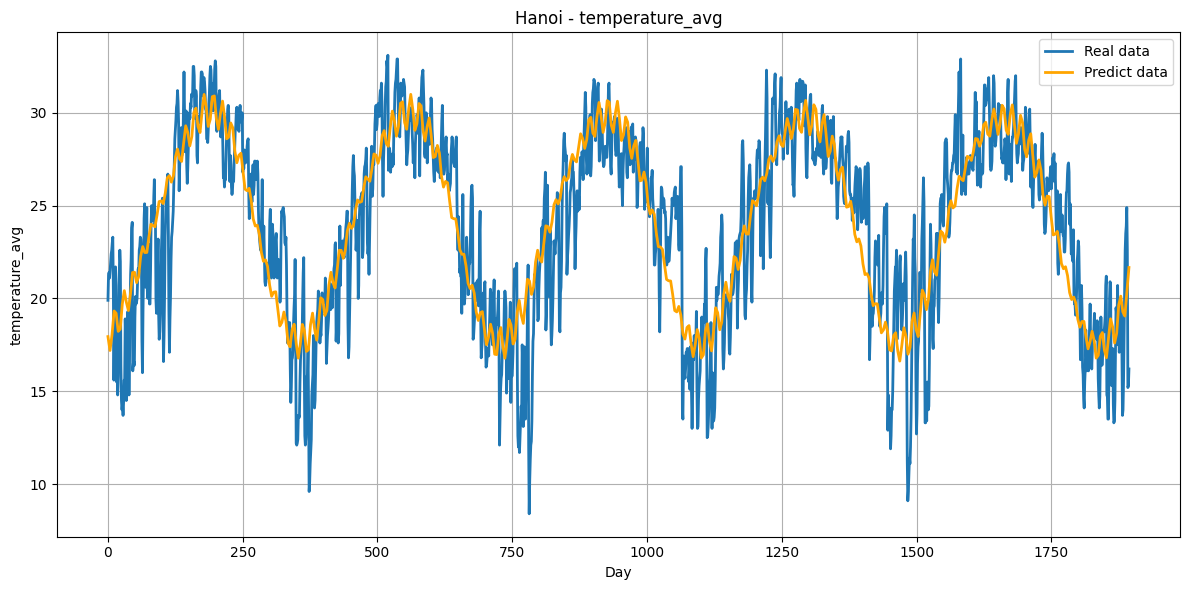


Hanoi - humidity_avg


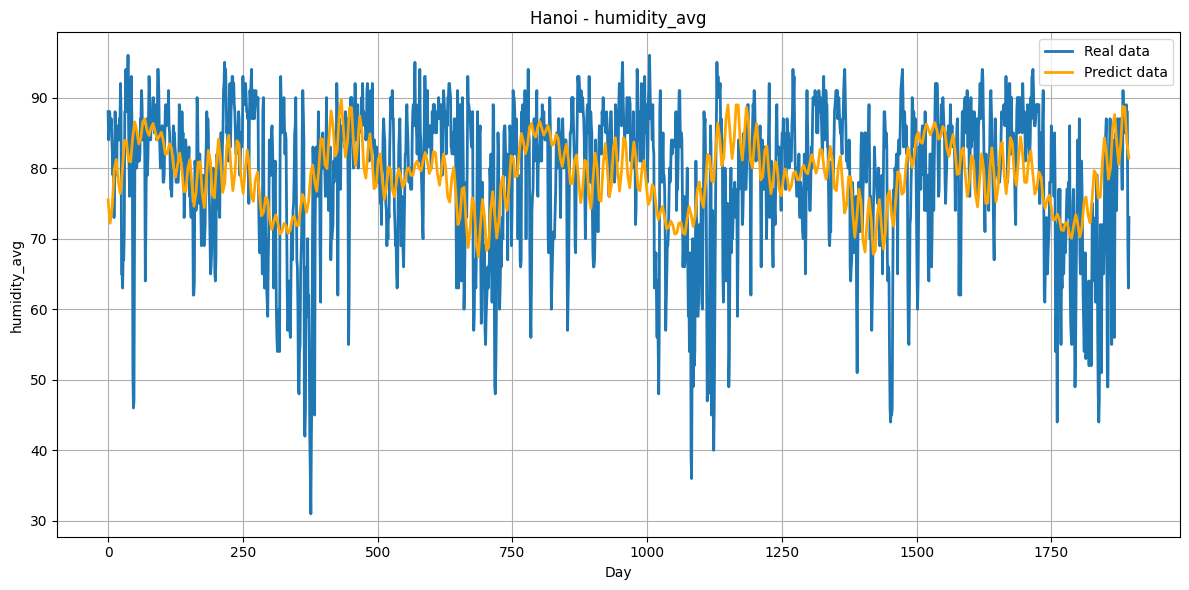


Hanoi - wind_speed_max


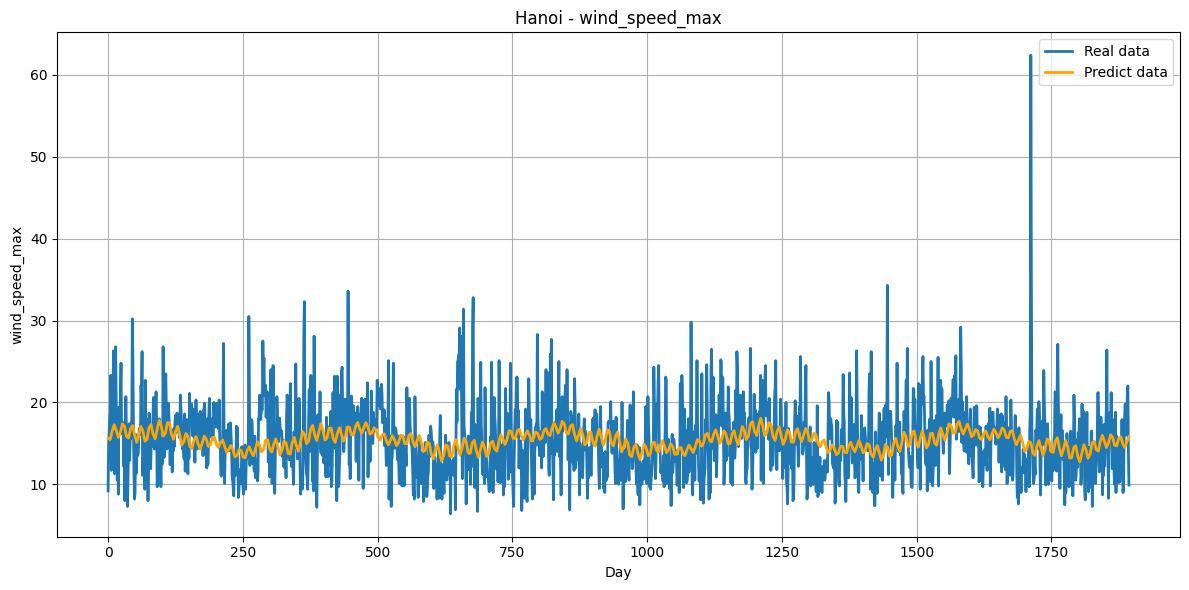


Moscow - temperature_avg


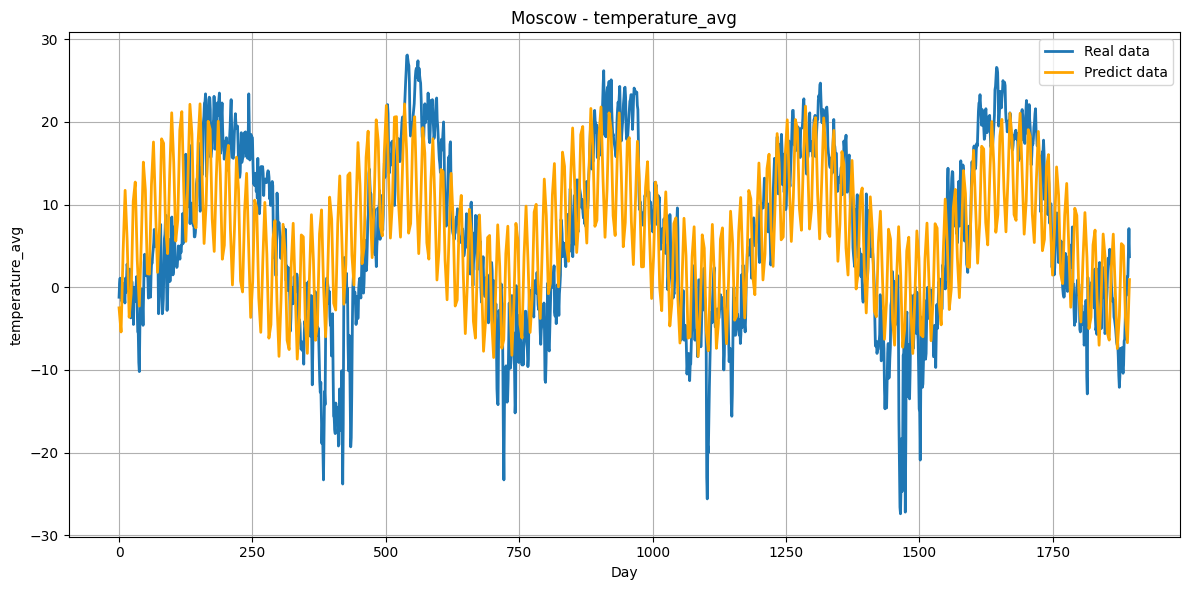


Moscow - humidity_avg


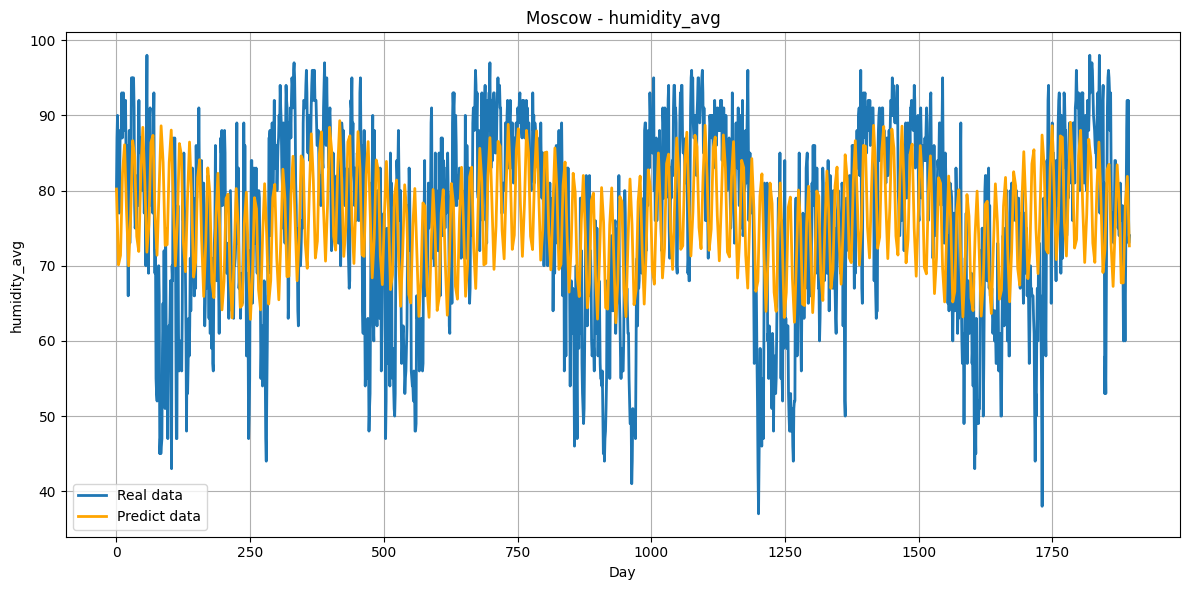


Moscow - wind_speed_max


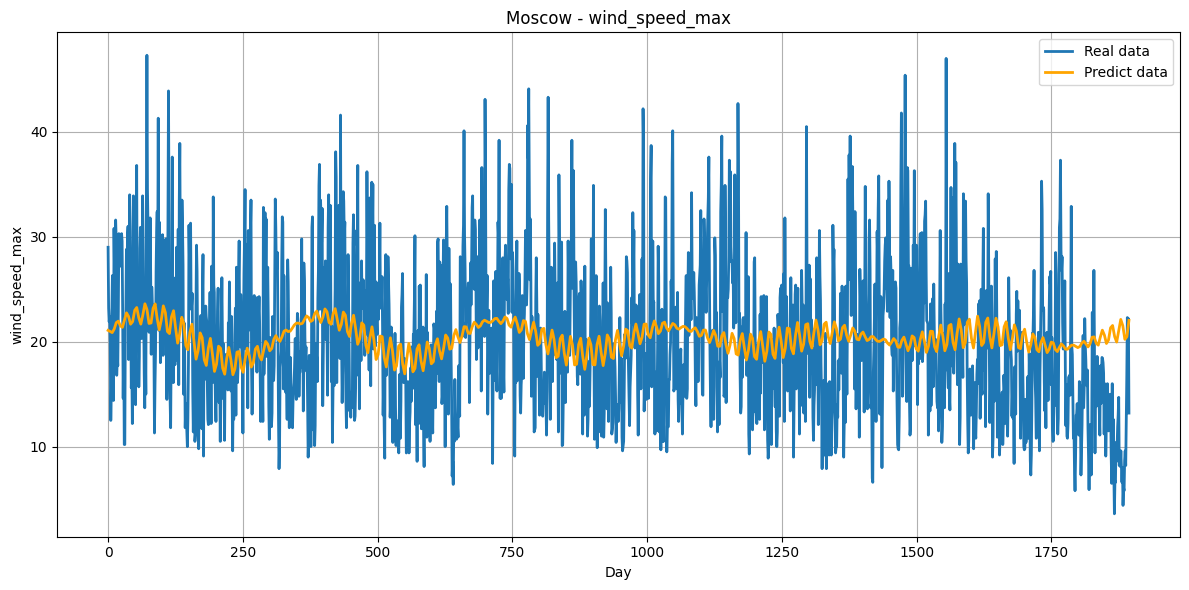


Berlin - temperature_avg


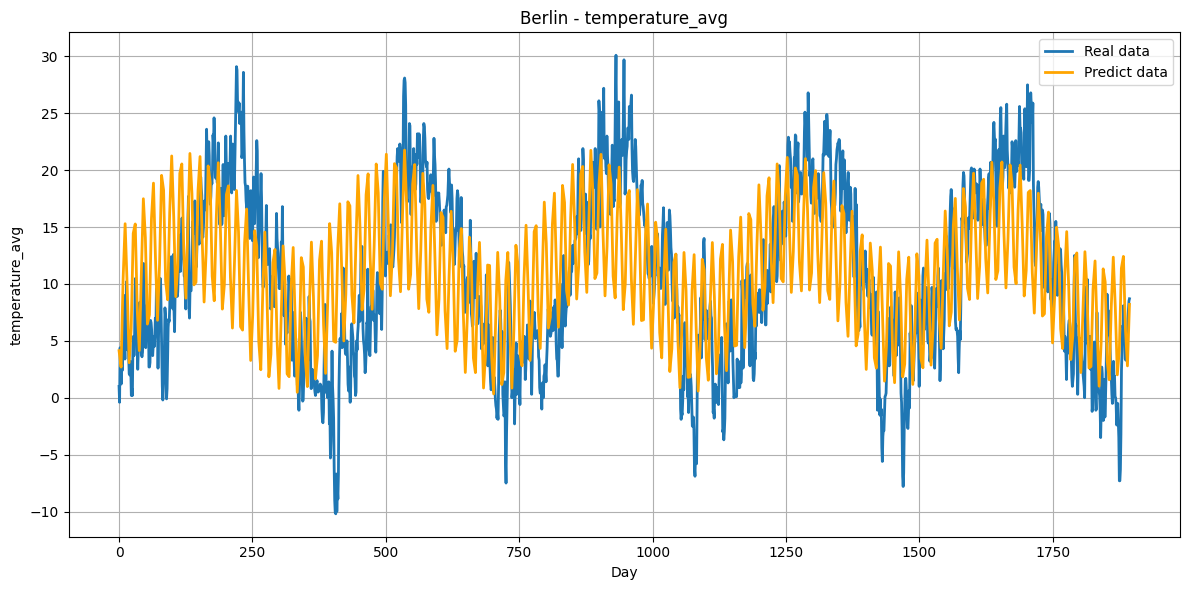


Berlin - humidity_avg


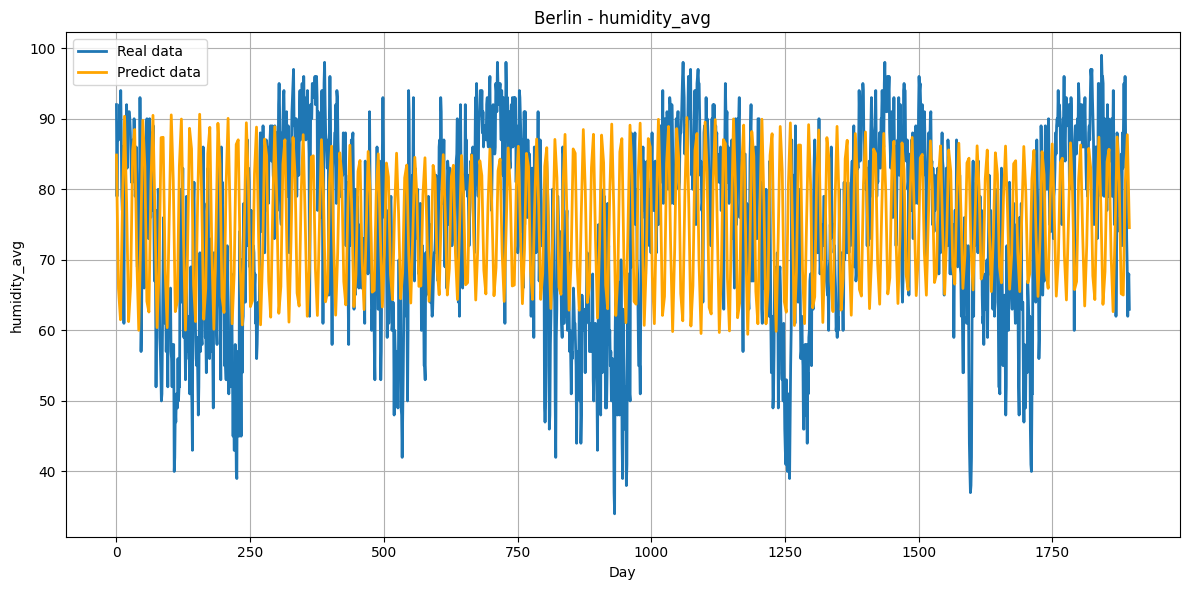


Berlin - wind_speed_max


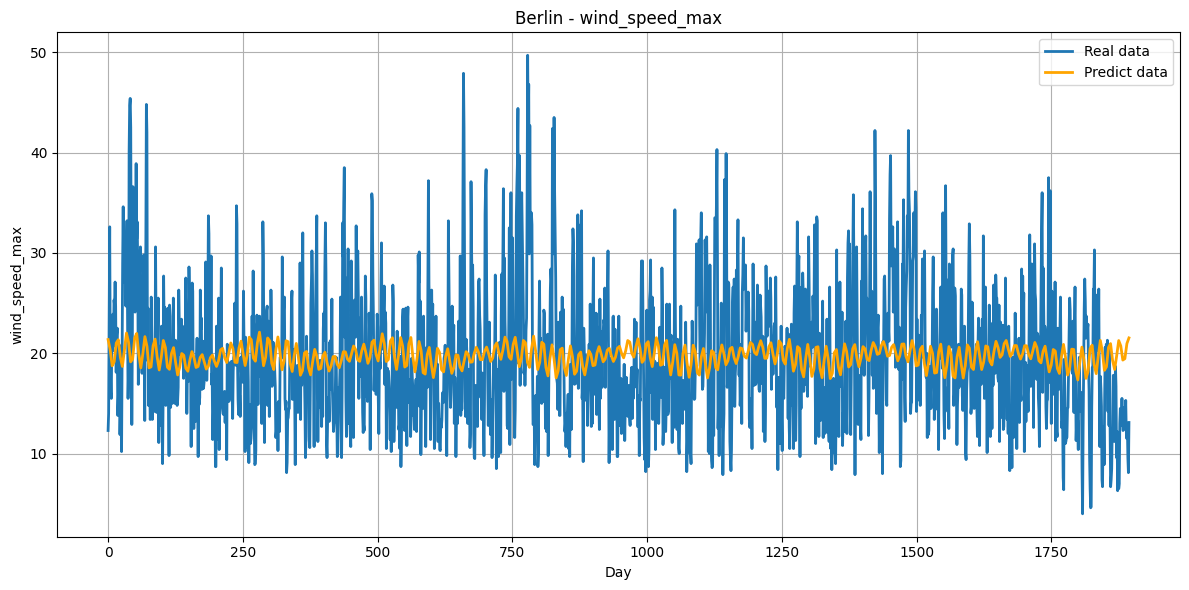

In [54]:
def plot_predictions(city_file, parameter, model, num_points=500):
    city_name = os.path.basename(city_file).replace('.csv', '')
    df = pd.read_csv(city_file)
    
    if parameter not in df.columns:
        return
    
    df['days'] = df['date'].apply(days_since_zero_date)
    
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    raw_data = data[:, 1].flatten()
    x_data = np.linspace(0, len(raw_data), len(raw_data))
    
    x_fine = np.linspace(0, len(raw_data), num_points)
    predictions = model.predict(x_fine.reshape(-1, 1), verbose=0).flatten()
    
    # Decoding predictions about the original domain
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    denormalized_predictions = normalize_class.DeNormalizeData(predictions, axes=0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_data, raw_data, linewidth=2, label='Real data')
    plt.plot(x_fine, denormalized_predictions, color='orange', linewidth=2, label='Predict data')
    plt.title(f'{city_name} - {parameter}')
    plt.xlabel('Day')
    plt.ylabel(f'{parameter}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

sample_cities = cities_files[:min(3, len(cities_files))]  

for city_file in sample_cities:
    city_name = os.path.basename(city_file).replace('.csv', '')
    
    if city_name in results:
        for param in parameters:
            if param in results[city_name]['models']:
                print(f"\n{city_name} - {param}")
                plot_predictions(city_file, param, results[city_name]['models'][param])

# save model
save_models = False  
if save_models:
    os.makedirs('optimized_models', exist_ok=True)
    
    for city_name, city_results in results.items():
        for param in city_results['models']:
            model = city_results['models'][param]
            model_path = f'optimized_models/{city_name}_{param}'
            model.save(model_path)
            print(f"Model saved for {city_name} - {param} at {model_path}")



Predict 30 next day for Hanoi:

temperature_avg:
          date  temperature_avg
0   2025-03-09        19.163900
1   2025-03-10        19.256222
2   2025-03-11        19.349525
3   2025-03-12        19.444082
4   2025-03-13        19.539654
5   2025-03-14        19.635553
6   2025-03-15        19.732969
7   2025-03-16        19.831202
8   2025-03-17        19.930021
9   2025-03-18        20.029686
10  2025-03-19        20.129967
11  2025-03-20        20.230652
12  2025-03-21        20.331972
13  2025-03-22        20.433445
14  2025-03-23        20.535431
15  2025-03-24        20.637877
16  2025-03-25        20.740589
17  2025-03-26        20.843328
18  2025-03-27        20.946367
19  2025-03-28        21.049469
20  2025-03-29        21.152466
21  2025-03-30        21.255463
22  2025-03-31        21.358526
23  2025-04-01        21.461300
24  2025-04-02        21.564058
25  2025-04-03        21.666571
26  2025-04-04        21.768698
27  2025-04-05        21.870628
28  2025-04-06        

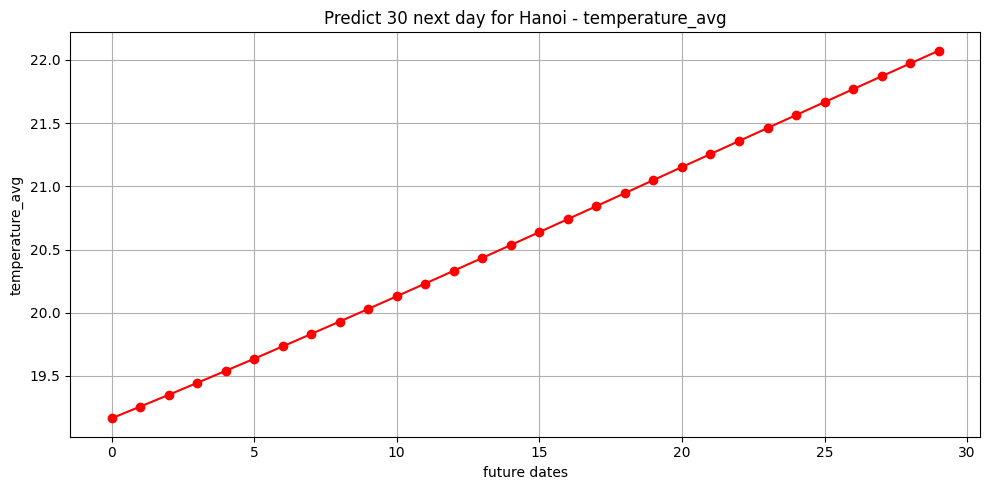


humidity_avg:
          date  humidity_avg
0   2025-03-09     79.859543
1   2025-03-10     79.972603
2   2025-03-11     80.082306
3   2025-03-12     80.187462
4   2025-03-13     80.289459
5   2025-03-14     80.387115
6   2025-03-15     80.480560
7   2025-03-16     80.570465
8   2025-03-17     80.655891
9   2025-03-18     80.737373
10  2025-03-19     80.814407
11  2025-03-20     80.887428
12  2025-03-21     80.955841
13  2025-03-22     81.020355
14  2025-03-23     81.080093
15  2025-03-24     81.135445
16  2025-03-25     81.186981
17  2025-03-26     81.233589
18  2025-03-27     81.276016
19  2025-03-28     81.314285
20  2025-03-29     81.347954
21  2025-03-30     81.377037
22  2025-03-31     81.402573
23  2025-04-01     81.423027
24  2025-04-02     81.439354
25  2025-04-03     81.451248
26  2025-04-04     81.459747
27  2025-04-05     81.463455
28  2025-04-06     81.462906
29  2025-04-07     81.459381


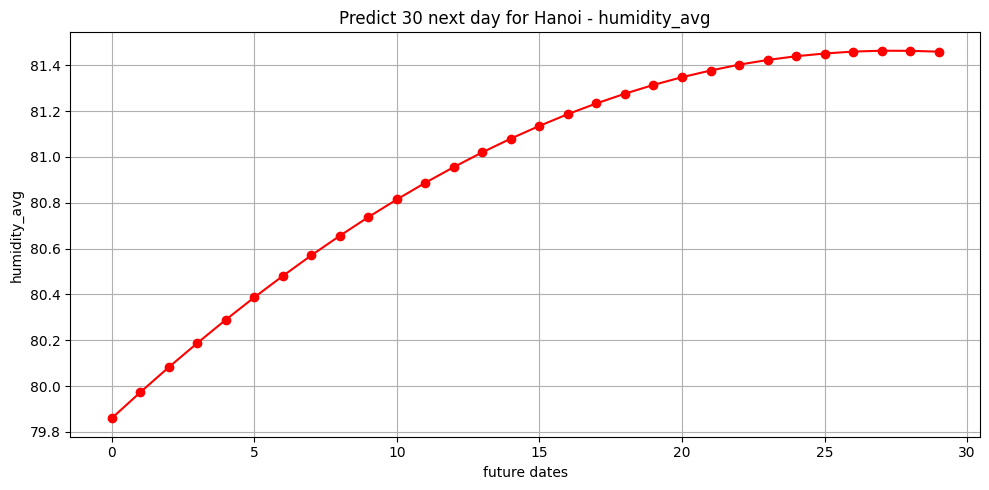


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       15.614823
1   2025-03-10       15.627880
2   2025-03-11       15.639681
3   2025-03-12       15.650337
4   2025-03-13       15.659945
5   2025-03-14       15.668637
6   2025-03-15       15.676064
7   2025-03-16       15.683267
8   2025-03-17       15.689889
9   2025-03-18       15.696033
10  2025-03-19       15.701829
11  2025-03-20       15.707380
12  2025-03-21       15.712795
13  2025-03-22       15.718184
14  2025-03-23       15.723413
15  2025-03-24       15.729081
16  2025-03-25       15.735020
17  2025-03-26       15.741316
18  2025-03-27       15.748054
19  2025-03-28       15.755317
20  2025-03-29       15.763178
21  2025-03-30       15.771699
22  2025-03-31       15.780936
23  2025-04-01       15.790997
24  2025-04-02       15.801848
25  2025-04-03       15.813552
26  2025-04-04       15.826132
27  2025-04-05       15.839605
28  2025-04-06       15.853987
29  2025-04-07       15.869276


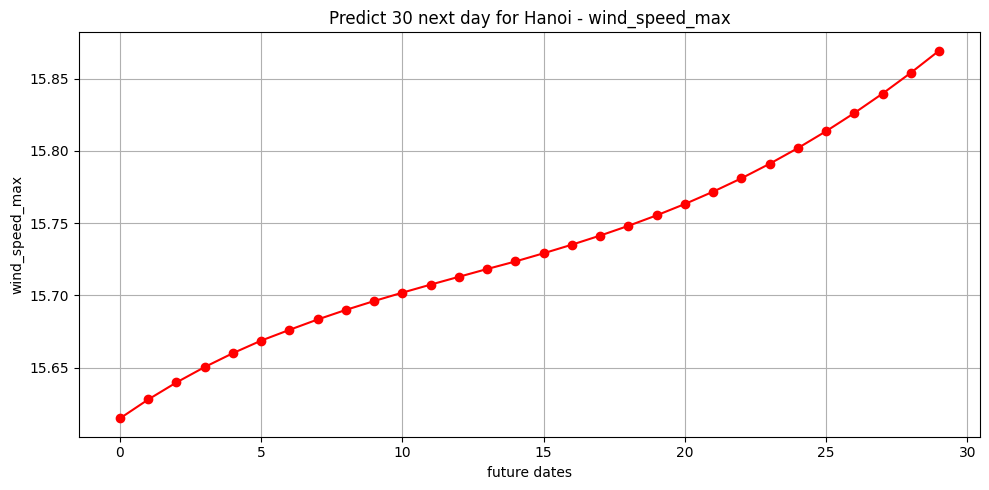


Predict 30 next day for Moscow:

temperature_avg:
          date  temperature_avg
0   2025-03-09        -3.471583
1   2025-03-10        -3.324314
2   2025-03-11        -3.174249
3   2025-03-12        -3.021327
4   2025-03-13        -2.865613
5   2025-03-14        -2.706831
6   2025-03-15        -2.545699
7   2025-03-16        -2.381982
8   2025-03-17        -2.215275
9   2025-03-18        -2.046558
10  2025-03-19        -1.875465
11  2025-03-20        -1.701473
12  2025-03-21        -1.525812
13  2025-03-22        -1.347997
14  2025-03-23        -1.168097
15  2025-03-24        -0.985425
16  2025-03-25        -0.801543
17  2025-03-26        -0.615798
18  2025-03-27        -0.427387
19  2025-03-28        -0.238114
20  2025-03-29        -0.047204
21  2025-03-30         0.145267
22  2025-03-31         0.340256
23  2025-04-01         0.535653
24  2025-04-02         0.732379
25  2025-04-03         0.931500
26  2025-04-04         1.130694
27  2025-04-05         1.330987
28  2025-04-06       

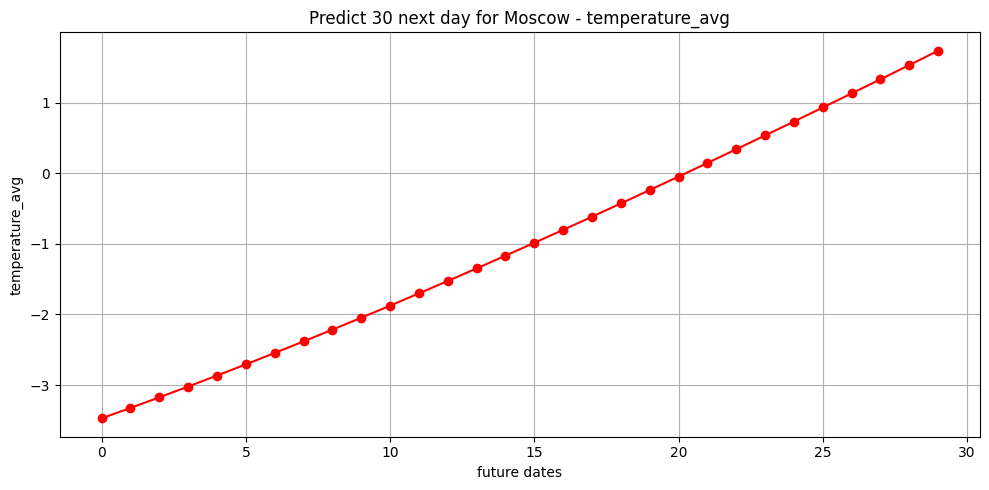


humidity_avg:
          date  humidity_avg
0   2025-03-09     78.904877
1   2025-03-10     78.665520
2   2025-03-11     78.417274
3   2025-03-12     78.167526
4   2025-03-13     77.924828
5   2025-03-14     77.673325
6   2025-03-15     77.428886
7   2025-03-16     77.175713
8   2025-03-17     76.921509
9   2025-03-18     76.675117
10  2025-03-19     76.420143
11  2025-03-20     76.164444
12  2025-03-21     75.916954
13  2025-03-22     75.661057
14  2025-03-23     75.404716
15  2025-03-24     75.156990
16  2025-03-25     74.901047
17  2025-03-26     74.653641
18  2025-03-27     74.398193
19  2025-03-28     74.142792
20  2025-03-29     73.896561
21  2025-03-30     73.642532
22  2025-03-31     73.388870
23  2025-04-01     73.144676
24  2025-04-02     72.892967
25  2025-04-03     72.641937
26  2025-04-04     72.400932
27  2025-04-05     72.152115
28  2025-04-06     71.913177
29  2025-04-07     71.667267


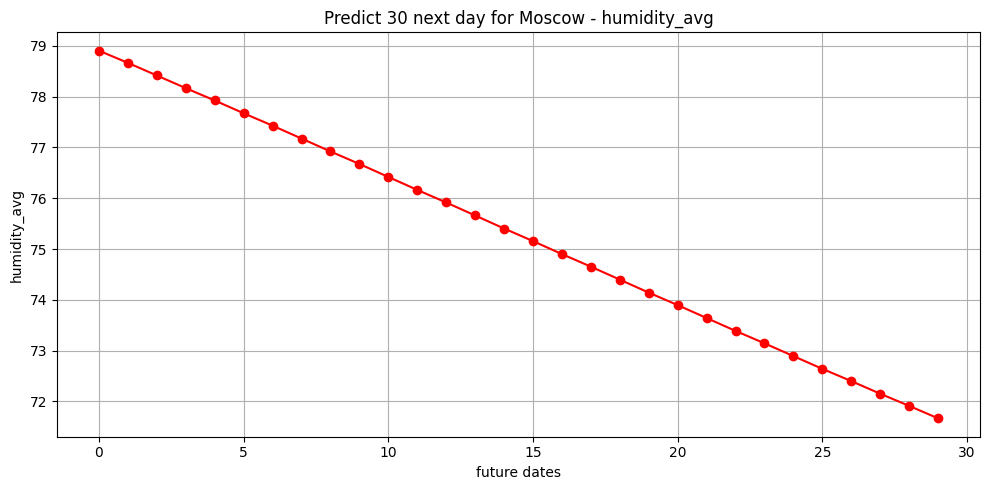


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       20.897587
1   2025-03-10       20.941788
2   2025-03-11       20.986574
3   2025-03-12       21.031673
4   2025-03-13       21.076941
5   2025-03-14       21.122604
6   2025-03-15       21.168436
7   2025-03-16       21.214525
8   2025-03-17       21.260262
9   2025-03-18       21.307140
10  2025-03-19       21.353590
11  2025-03-20       21.400166
12  2025-03-21       21.446678
13  2025-03-22       21.492722
14  2025-03-23       21.539719
15  2025-03-24       21.586023
16  2025-03-25       21.632393
17  2025-03-26       21.678368
18  2025-03-27       21.723745
19  2025-03-28       21.769863
20  2025-03-29       21.814705
21  2025-03-30       21.860184
22  2025-03-31       21.904621
23  2025-04-01       21.948330
24  2025-04-02       21.992529
25  2025-04-03       22.035286
26  2025-04-04       22.078428
27  2025-04-05       22.120068
28  2025-04-06       22.161314
29  2025-04-07       22.202545


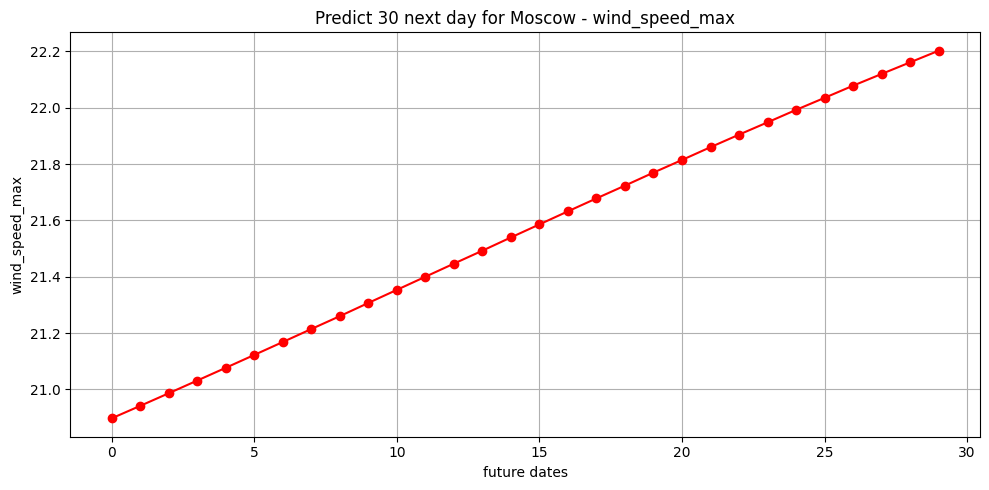


Predict 30 next day for Berlin:

temperature_avg:
          date  temperature_avg
0   2025-03-09         3.986038
1   2025-03-10         4.129349
2   2025-03-11         4.275450
3   2025-03-12         4.425882
4   2025-03-13         4.577357
5   2025-03-14         4.733099
6   2025-03-15         4.889580
7   2025-03-16         5.048384
8   2025-03-17         5.211335
9   2025-03-18         5.374557
10  2025-03-19         5.541831
11  2025-03-20         5.709058
12  2025-03-21         5.878107
13  2025-03-22         6.051059
14  2025-03-23         6.223494
15  2025-03-24         6.399717
16  2025-03-25         6.575100
17  2025-03-26         6.751779
18  2025-03-27         6.932071
19  2025-03-28         7.111057
20  2025-03-29         7.293536
21  2025-03-30         7.474409
22  2025-03-31         7.656034
23  2025-04-01         7.840960
24  2025-04-02         8.023828
25  2025-04-03         8.207141
26  2025-04-04         8.393559
27  2025-04-05         8.577492
28  2025-04-06       

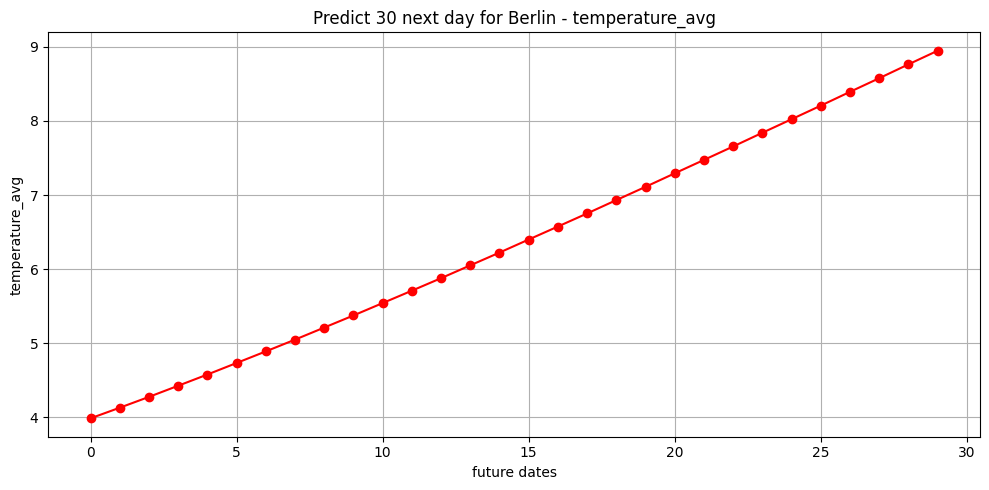


humidity_avg:
          date  humidity_avg
0   2025-03-09     80.788460
1   2025-03-10     80.560806
2   2025-03-11     80.329277
3   2025-03-12     80.106606
4   2025-03-13     79.870056
5   2025-03-14     79.632057
6   2025-03-15     79.390701
7   2025-03-16     79.158989
8   2025-03-17     78.913345
9   2025-03-18     78.666527
10  2025-03-19     78.416862
11  2025-03-20     78.177574
12  2025-03-21     77.924408
13  2025-03-22     77.670326
14  2025-03-23     77.413948
15  2025-03-24     77.168617
16  2025-03-25     76.909538
17  2025-03-26     76.649826
18  2025-03-27     76.388374
19  2025-03-28     76.138565
20  2025-03-29     75.875237
21  2025-03-30     75.611565
22  2025-03-31     75.346718
23  2025-04-01     75.094048
24  2025-04-02     74.828163
25  2025-04-03     74.562241
26  2025-04-04     74.295700
27  2025-04-05     74.041801
28  2025-04-06     73.775085
29  2025-04-07     73.508629


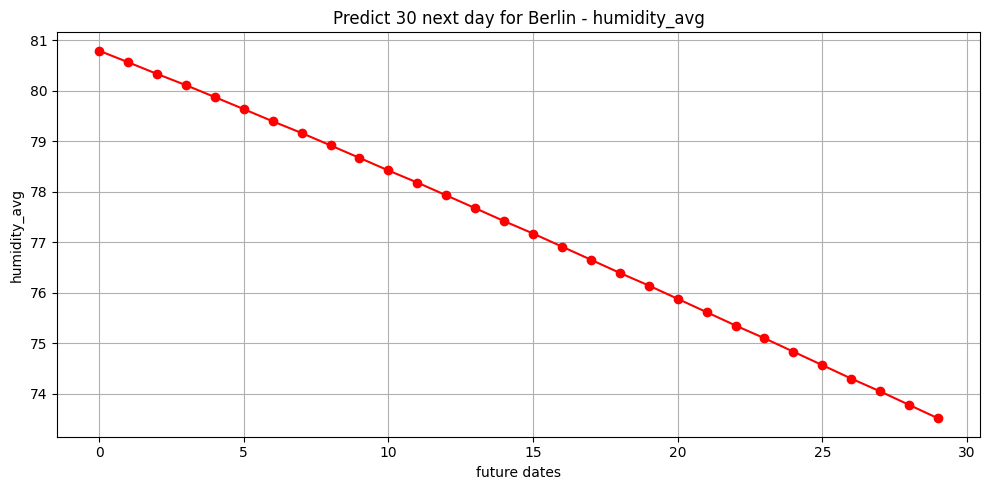


wind_speed_max:
          date  wind_speed_max
0   2025-03-09       21.139215
1   2025-03-10       21.165964
2   2025-03-11       21.193274
3   2025-03-12       21.220984
4   2025-03-13       21.248922
5   2025-03-14       21.277306
6   2025-03-15       21.305141
7   2025-03-16       21.333187
8   2025-03-17       21.360033
9   2025-03-18       21.386059
10  2025-03-19       21.411032
11  2025-03-20       21.435194
12  2025-03-21       21.457390
13  2025-03-22       21.477859
14  2025-03-23       21.496391
15  2025-03-24       21.513210
16  2025-03-25       21.527761
17  2025-03-26       21.539333
18  2025-03-27       21.548271
19  2025-03-28       21.554447
20  2025-03-29       21.557758
21  2025-03-30       21.558128
22  2025-03-31       21.555992
23  2025-04-01       21.550344
24  2025-04-02       21.541901
25  2025-04-03       21.530222
26  2025-04-04       21.515612
27  2025-04-05       21.498161
28  2025-04-06       21.478436
29  2025-04-07       21.455650


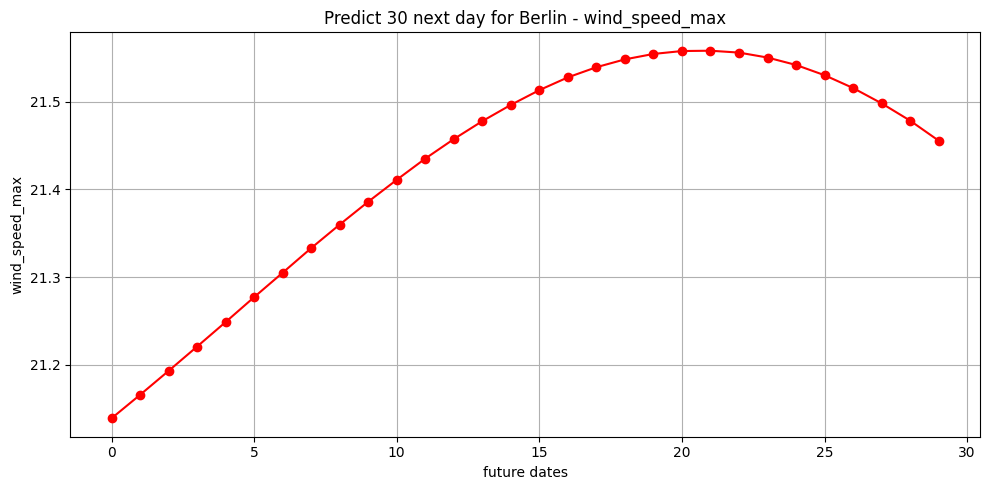

In [48]:
# predict in future
def predict_future(city_file, parameter, model, days_ahead=30):
    city_name = os.path.basename(city_file).replace('.csv', '')
    df = pd.read_csv(city_file)
    
    if parameter not in df.columns:
        return None
    
    df['days'] = df['date'].apply(days_since_zero_date)
    
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    normalize_class = Normalize(data[:, 1].reshape(-1, 1))
    normalized_data = normalize_class.normalizeData().flatten()
    
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        return None
    
    denoised_data = denoise_data(normalized_data, window_size)
    x_data = np.linspace(0, len(denoised_data), len(denoised_data))
    
    # Create future data points
    future_days = np.linspace(len(denoised_data), len(denoised_data) + days_ahead, days_ahead + 1)
    
    # predict
    future_predictions = model.predict(future_days.reshape(-1, 1), verbose=0).flatten()
    
    # Decoding predictions about the original domain
    denormalized_predictions = normalize_class.DeNormalizeData(future_predictions, axes=0)
    
    # Create future dates
    last_date = df['date'].iloc[-1]
    last_date_obj = datetime.strptime(last_date, "%Y-%m-%d")
    future_dates = [(last_date_obj + pd.Timedelta(days=i+1)).strftime("%Y-%m-%d") for i in range(days_ahead)]
    
    # Create DataFrame result
    future_df = pd.DataFrame({
        'date': future_dates,
        parameter: denormalized_predictions[1:], 
    })
    
    return future_df

days_to_predict = 30

for city_file in sample_cities:
    city_name = os.path.basename(city_file).replace('.csv', '')
    
    if city_name in results:
        print(f"\nPredict {days_to_predict} next day for {city_name}:")
        
        for param in parameters:
            if param in results[city_name]['models']:
                future_df = predict_future(city_file, param, results[city_name]['models'][param], days_to_predict)
                
                if future_df is not None:
                    print(f"\n{param}:")
                    print(future_df)  
                    plt.figure(figsize=(10, 5))
                    plt.plot(range(len(future_df)), future_df[param], 'r-o')
                    plt.title(f'Predict {days_to_predict} next day for {city_name} - {param}')
                    plt.xlabel('future dates')
                    plt.ylabel(param)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()